# 4.2.5 Boston Marathon

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [43]:
data = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
data.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [44]:
data.isnull().sum()

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64

In [45]:
# Deriving the column flag to determine if its male or not
data['Male_Flag']=np.where(data['gender']=='M',1,0)

In [46]:
# Taking the relevant number of columns for the clustering 
df= data[['division', 'age', 'official', 'genderdiv', 'overall', 'pace', 'Male_Flag']]
#df = pd.DataFrame(data=df)


In [47]:
#Check the number of nulls in the records
df.isnull().sum()

division     0
age          0
official     0
genderdiv    0
overall      0
pace         0
Male_Flag    0
dtype: int64

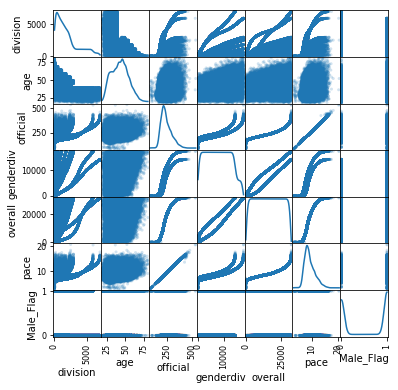

In [52]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde');

Text(0.5,1,'Age Histogram')

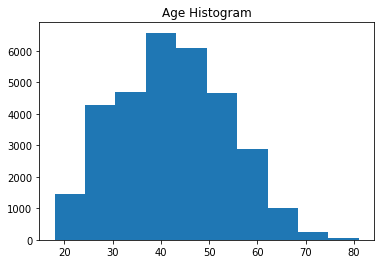

In [56]:
plt.hist(df['age'])
plt.title("Age Histogram")

# X and Y AS input variables and outcome variable

In [71]:
X=df.iloc[:,0:6]
Y=df.iloc[:,6]

Text(0.5,1,'Variable Correlation')

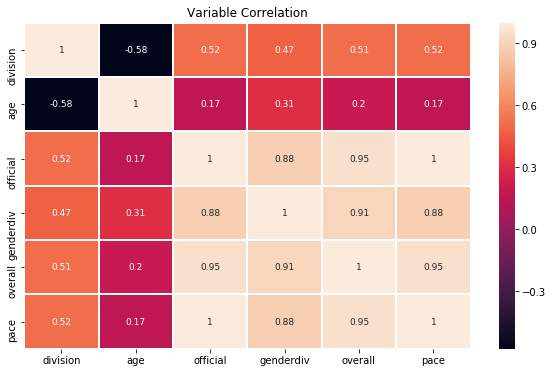

In [64]:
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(),linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

There look to be some correlation between the features as seen above in the correlation matrix

# K-MEANS CLUSTER

In [123]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to five components.
X_pca = PCA(5).fit_transform(X_norm)
#for i in np.arange(2,6,1):
# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Check the solution against the data.
 #print('Comparing {}-means clusters against the data'.format(i))
print(pd.crosstab( Y,y_pred))

col_0          0      1
Male_Flag              
0          14344     23
1           7412  10205


In [124]:
y_full = KMeans(n_clusters=3, random_state=42).fit_predict(X_norm)
metrics.adjusted_rand_score(Y, y_full)

0.8122894205424661

# Lets try  MiniBatch to see the difference in performance

In [127]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print(pd.crosstab(predict_mini, y_pred))

col_0      0      1
row_0              
0      21407      0
1        349  10228


In [128]:
metrics.adjusted_rand_score(predict_mini, y_pred)

0.9561756285055765

# Mean Shift

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.9,
    random_state=42)
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 2


In [145]:
#metrics.adjusted_rand_score(y_train, labels)
print(metrics.silhouette_score(X_train, labels, metric='euclidean'))

0.5588994281425014


# Spectral clustering

In [153]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=5

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

C:\Users\09142640\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\09142640\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Comparing the assigned categories to the ones in the data:
col_0         0  1  2  3  4
Male_Flag                  
0          1422  2  2  0  0
1          1764  4  0  2  2


In [155]:
metrics.adjusted_rand_score(y_train,predict)

-0.00036866952971958186

In [156]:
print(metrics.silhouette_score(X_train, predict, metric='euclidean'))

-0.42705459013296304


# Affinity Propagation

In [159]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
af = AffinityPropagation().fit(X_train)
#print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Estimated number of clusters: 1288


# Conclusion:

For this data set, Mini Batch K-Means yielded the best results, with excellent Adjusted Rand Score that there was nearly perfect agreement between the ground truth and the new solution. Normal K-Means also worked reasonably well, with  ARI of 0.812. Mean Shift worked very poorly, same for  Spectral Clustering and affinity clustering as well.Changing the numner of clusters didnot really improve the rand score